### 1．インポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from urllib.request import urlopen

### 1.1　クラス

In [2]:
# 訓練データと出馬表データを加工する抽象クラス
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame()
        # preprocessing後の変数
        self.data_p = pd.DataFrame()
        # horse_resultsをmergeした後の変数
        self.data_h = pd.DataFrame()
        # pedsをmergeした後の変数
        self.data_pe = pd.DataFrame()
        # カテゴリ変数化した後の変数
        self.data_c = pd.DataFrame()
        
    # 馬の過去成績データの追加
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
            
    # 血統データ追加
    def merge_peds(self, peds):
        self.data_pe = self.data_h.merge(peds, left_on='horse_id', right_index=True, how='left')
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]['horse_id'].unique()
        if len(self.no_peds):
            print('scrape peds at horse_id_list "no_peds"')
    
    # カテゴリ変数の処理
    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.data_pe.copy()
        
        # ラベルエンコーディング(horse_id, jockey_idを0始まりの整数に変換)
        # horse_id
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        # jockey_id
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        # horse_id, jockey_idをcategory型に変換
        df['horse_id'] = df['horse_id'].astype('category')
        df['jockey_id'] = df['jockey_id'].astype('category')
        
        # そのほかのカテゴリ変数をcategory型に変換してからダミー変数化
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])  
        self.data_c = df

# 予測に使う出馬表データを加工するクラス
class ShutubaTable(DataProcessor):
    def __init__(self, shutuba_tables):
        super(ShutubaTable, self).__init__()
        self.data = shutuba_tables
    
    @classmethod
    def scrape(cls, race_id_list, date):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            url = f'https://race.netkeiba.com/race/shutuba.html?race_id={race_id}'
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            # race_data
            texts = soup.find('div', attrs={'class': 'RaceData01'}).text
            texts = re.findall(r'\w+', texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                    df['weather'] = [text] * len(df)
                if text in ['良', '稍重', '重']:
                    df['ground_state'] = [text] * len(df)
                if '不' in text:
                    df['ground_state'] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)

            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all('td', attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            df['horse_id'] = horse_id_list

            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all('td', attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            data = data.append(df)
            time.sleep(1)
        
        return cls(data)
    
    # 前処理
    def preprocessing(self):
        df = self.data.copy()
        
        # 性齢を性と年齢に分ける
        df['性'] = df['性齢'].map(lambda x: str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df = df[df['馬体重(増減)'] != '--']
        df['体重'] = df['馬体重(増減)'].str.split('(', expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重(増減)'].str.split('(', expand=True)[1].str[:-1].astype(int)
        
        # 日付をdatetime型に変更
        df['date'] = pd.to_datetime(df['date'])

        # データをint, floatに変換
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)

    
        # 必要な列だけにする
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather', 'race_type', 'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢', '体重', '体重変化']]

        self.data_p = df.rename(columns={'枠': '枠番'})

# 訓練に使う過去レースデータを加工するクラス
class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list):
        # race_idをkeyにしてDataFrame型を格納
        race_results = {}
        for race_id in tqdm(race_id_list):
            time.sleep(1)
            try:
                url = f'https://db.netkeiba.com/race/{race_id}'
                # メインとなるテーブルデータを取得
                df = pd.read_html(url)[0]

                html = requests.get(url)
                html.encoding = 'EUC-JP'
                soup = BeautifulSoup(html.text, 'html.parser')

                # 天候、レースの種類、コースの長さ、馬場の状態、日付をスクレイピング
                texts = (
                    soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[0].text
                    + soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[1].text
                )
                info = re.findall(r'\w+', texts)
                for text in info:
                    if text in ['芝', 'ダート']:
                        df['race_type'] = [text] * len(df)
                    if '障' in text:
                        df['race_type'] = ['障害'] * len(df)
                    if 'm' in text:
                        df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                    if text in ['良', '稍重', '重', '不良']:
                        df['ground_state'] = [text] * len(df)
                    if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                        df['weather'] = [text] * len(df)
                    if '年' in text:
                        df['date'] = [text] * len(df)

                # 馬ID、騎手IDをスクレイピング
                horse_id_list = []
                horse_a_list = soup.find('table', attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/horse')})
                for a in horse_a_list:
                    horse_id = re.findall(r'\d+', a['href'])
                    horse_id_list.append(horse_id[0])
                jockey_id_list = []
                jockey_a_list = soup.find("table", attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/jockey')})
                for a in jockey_a_list:
                    jockey_id = re.findall(r'\d+', a['href'])
                    jockey_id_list.append(jockey_id[0])
                df['horse_id'] = horse_id_list
                df['jockey_id'] = jockey_id_list

                #インデックスをrace_idにする
                df.index = [race_id] * len(df)

                race_results[race_id] = df
            # 存在しないrace_idを飛ばす
            except IndexError:
                continue
            # wifiの接続が切れた時などでも途中までのデータを返せるようにする
            except Exception as e:
                print(e)
                break
            # Jupyterで停止ボタンを押した時の対処
            except:
                break

        # pd.DataFrame型にして一つのデータにまとめる
        race_results_df = pd.concat([race_results[key] for key in race_results])

        return race_results_df
    
    # 前処理
    def preprocessing(self):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df = df[~(df['着順'].astype(str).str.contains('\D'))]
        df['着順'] = df['着順'].astype(int)
        df['rank'] = df['着順'].map(lambda x: 1 if x < 4 else 0)

        # 性齢を性と年齢に分ける
        df['性'] = df['性齢'].map(lambda x: str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df['体重'] = df['馬体重'].str.split('(', expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重'].str.split('(', expand=True)[1].str[:-1].astype(int)

        # データをint, floatに変換
        df['単勝'] = df['単勝'].astype(float)
        df['course_len'] = df['course_len'].astype(int)

        # 不要な列を削除
        df.drop(['タイム', '着差', '調教師', '性齢', '馬体重', '馬名', '騎手', '単勝', '人気', '着順'], axis=1, inplace=True)

        df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')

        self.data_p = df
    
    # カテゴリ変数の処理
    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])        
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)

# 馬の過去成績データを処理するクラス
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金']]
        self.preprocessing()
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        # horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            try:
                time.sleep(1)
                url = f'https://db.netkeiba.com/horse/{horse_id}'
                # メインとなるテーブルデータを取得
                df = pd.read_html(url)[3]
                # 受賞歴がある馬の場合、4番目に受賞歴テーブルが来るため、5番目のデータを取得する
                if df.columns[0] == '受賞歴':
                    df = pd.read_html(url)[4]
                horse_results[horse_id] = df
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # pd.DataFrame型にして一つのデータにまとめる
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])
        
        return horse_results_df
        
    def preprocessing(self):
        df = self.horse_results.copy()
        
        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        
        df['date'] = pd.to_datetime(df['日付'])
        df.drop(['日付'], axis=1, inplace=True)
        
        # 賞金の欠損値を0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        self.horse_results = df
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')
        
        # 過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be integer')
            
        average = filtered_df.groupby(level=0)[['着順', '賞金']].mean()
        rename_columns = average.rename(columns={'着順': f'着順_{n_samples}R', '賞金': f'賞金_{n_samples}R'})
        return rename_columns
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in date_list])
        return merged_df

# 血統データを処理するクラス
class Peds:
    def __init__(self, peds):
        self.peds = peds
        # LabelEncodingしてcategory型にした変数
        self.peds_e = pd.DataFrame()
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        # 血統データを取り出す
        peds_dict = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = f'https://db.netkeiba.com/horse/ped/{horse_id}'
                df = pd.read_html(url)[0]

                # 重複を削除して1列のSeries型データに治す
                generations = {}
                for i in reversed(range(5)):
                    generations[i] = df[i]
                    df.drop([i], axis=1, inplace=True)
                    df = df.drop_duplicates()

                ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
                peds_dict[horse_id] = ped.reset_index(drop=True)
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # 列名をpeds_0, ..., peds_61にする
        peds_df = pd.concat([peds_dict[key] for key in peds_dict], axis=1).T.add_prefix('peds_')
        
        return peds_df
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')

# 払い戻しデータを加工するクラス
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list):
        return_tables = {}
        for race_id in tqdm(race_id_list):
            try:
                url = f'https://db.netkeiba.com/race/{race_id}'

                # 複勝やワイドなどが区切られてしまうため、改行コードを文字列に変換して後でsplitする
                f = urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')            
                dfs = pd.read_html(html)

                # dfsの2番目に単勝～馬連、3番目にワイド～3連単がある
                df = pd.concat([dfs[1], dfs[2]])
                
                df.index = [race_id] * len(df)
                return_tables[race_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        
        return return_tables_df
    
    @property
    def fukusho(self):
        # 複勝の勝ち馬と払い戻しのデータを取り出す
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1, 2]]
        
        # 勝ち馬
        wins = fukusho[1].str.split('br', expand=True)[[0, 1, 2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        
        # 払い戻し
        returns = fukusho[2].str.split('br', expand=True)[[0, 1, 2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        
        # int型に変換できないデータがあるので処理
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
            
        df = df.fillna(0).astype(int)
        
        return df
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1, 2]]
        tansho.columns = ['win', 'return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
            
        return tansho

# 予測モデルを評価するクラス
class ModelEvaluator:
    def __init__(self, model, return_tables_path, std=True):
        self.model = model
        self.fukusho = Return.read_pickle([return_tables_path]).fukusho
        self.tansho = Return.read_pickle([return_tables_path]).tansho
        self.std = std
        
    def predict_proba(self, x):
        # 1（3着以内）になる確率を予測
        proba = pd.Series(self.model.predict_proba(x)[:, 1], index=x.index)
        if self.std:
            # 標準化
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            # MinMaxスケーリング：データを0から1にする
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    def predict(self, x, threshold=0.5):
        # thresholdの値によってpredict_probaで出した値を0か1に決定する
        y_pred = self.predict_proba(x)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def score(self, y_true, x):
        # スコアを表示
        return roc_auc_score(y_true, self.predict_proba(x))
    
    def feature_importance(self, x, n_display=20):
        # 変数の重要度を出力
        importances = pd.DataFrame(
            {"features": x.columns, "importance": self.model.feature_importances_}
        )
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, x, threshold=0.5, bet_only=True):
        # 予測したレースIDと馬番を出力する
        pred_table = x.copy()[['馬番']]
        pred_table['pred'] = self.predict(x, threshold)
        
        if bet_only:
            return pred_table[pred_table['pred'] == 1]['馬番']
        
        return pred_table
    
    def fukusho_return(self, x, threshold=0.5):
        # 複勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df[f'win_{i}'] == df['馬番']][f'return_{i}'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return(self, x, threshold=0.5):
        # 単勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        money += df[df['win'] == df['馬番']]['return'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        # 単勝適性回収値を計算
        return_rate = len(df.query('win == 馬番')) / (100 / df['return']).sum()
        
        return n_bets, return_rate

### 1.2　関数

In [3]:
# 時系列に沿って訓練データとテストデータに分ける関数
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()   
    train_id_list = sorted_id_list[:round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)):]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

# 回収率を計算する関数
def gain(return_func, x, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = (i / n_samples) + (min_threshold * (1 - (i / n_samples)))
        n_bets, return_rate = return_func(x, threshold)
        if n_bets > lower:
            gain[n_bets] = return_rate
    return pd.Series(gain)

# 重複のないデータを作成する関数
def update_data(old, new):
    filtered_old = old[~old.index.isin(new.index)]
    return pd.concat([filtered_old, new])

### 2．前処理

In [4]:
r = Results.read_pickle(['results.pickle'])

# 前処理
r.preprocessing()

# 馬の過去成績データの追加
hr = HorseResults.read_pickle(['horse_results.pickle'])
r.merge_horse_results(hr)

# 5世代分の血統データの追加
p = Peds.read_pickle(['peds.pickle'])
p.encode()
r.merge_peds(p.peds_e)

# カテゴリ変数の処理
r.process_categorical()

### 3．予測

In [5]:
train, test = split_data(r.data_c)
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [6]:
params = {
    'num_leaves': 4,
    'n_estimators': 80,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [7]:
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')

100%|██████████| 100/100 [02:59<00:00,  1.79s/it]


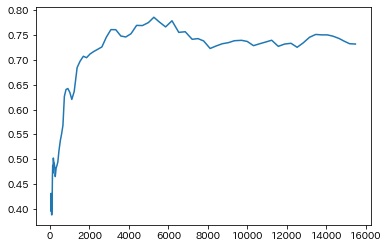

In [8]:
baseline = gain(me.tansho_return, X_test)
baseline.plot()

#### 4．単勝適性回収値
常に払戻額が一定になるように単勝で賭けた場合の回収率<br>
払戻額が常に1万円になるように賭けてみる

賭けた金額<br>
x円賭けるとすると<br>
$$
各馬番の単勝オッズ \times \frac{x}{100} = 10000 \\
\therefore \quad x = \frac{100 \times 10000}{各馬番の単勝オッズ}
$$

回収率 = 払戻額 / 賭けた金額

100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


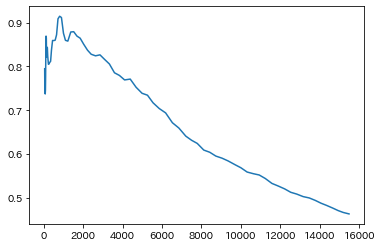

In [9]:
gain_proper = gain(me.tansho_return_proper, X_test)
gain_proper.plot()

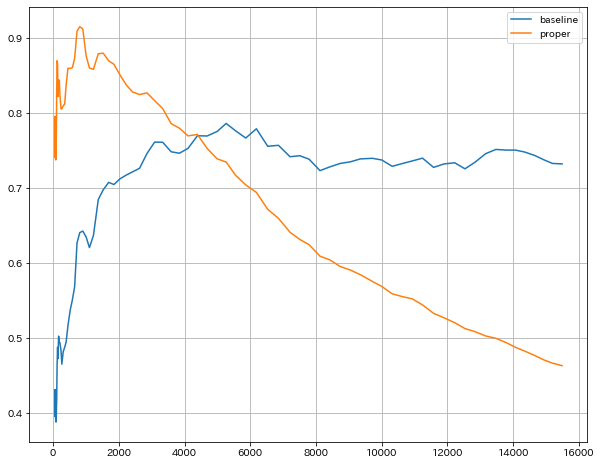

In [10]:
plt.figure(figsize=(10, 8))
baseline.rename('baseline').plot(legend=True)
gain_proper.rename('proper').plot(legend=True)
plt.grid()

### 5．Optuna

In [11]:
train, test = split_data(r.data_c)
train, valid = split_data(train)

In [12]:
import optuna.integration.lightgbm as lgb_o

# 説明変数と目的変数に分ける
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date'], axis=1)
y_valid = valid['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [13]:
# データセットの作成
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

# チューニング実行
params = {
    'objective': 'binary',
    'random_state': 100
}

lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_train, lgb_valid), verbose_eval=100, early_stopping_rounds=10)

[I 2022-03-21 15:02:12,367] A new study created in memory with name: no-name-12ead92d-13f3-4aa2-8b19-d826e78eddf6
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.466295:  14%|#4        | 1/7 [00:02<00:17,  2.84s/it]

Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.428393	valid_1's binary_logloss: 0.466295
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.466295:  29%|##8       | 2/7 [00:05<00:13,  2.69s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.430351	valid_1's binary_logloss: 0.466859
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.466295:  43%|####2     | 3/7 [00:08<00:11,  2.90s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.436656	valid_1's binary_logloss: 0.467666
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.466295:  57%|#####7    | 4/7 [00:11<00:08,  2.81s/it]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.439963	valid_1's binary_logloss: 0.467039
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.466295:  71%|#######1  | 5/7 [00:14<00:05,  2.97s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.422333	valid_1's binary_logloss: 0.46694
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.466295:  86%|########5 | 6/7 [00:17<00:02,  3.00s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.435011	valid_1's binary_logloss: 0.467842
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.432324	valid_1's binary_logloss: 0.465903
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:   5%|5         | 1/20 [00:04<01:30,  4.76s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.357829	valid_1's binary_logloss: 0.474138
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  10%|#         | 2/20 [00:07<01:17,  4.28s/it]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.39649	valid_1's binary_logloss: 0.468198
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  15%|#5        | 3/20 [00:12<01:12,  4.26s/it]

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.360039	valid_1's binary_logloss: 0.470562
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  20%|##        | 4/20 [00:16<01:08,  4.28s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.355831	valid_1's binary_logloss: 0.473266
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  25%|##5       | 5/20 [00:20<01:01,  4.08s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.388824	valid_1's binary_logloss: 0.471129
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  30%|###       | 6/20 [00:22<00:52,  3.71s/it]

Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.425261	valid_1's binary_logloss: 0.46612
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  35%|###5      | 7/20 [00:26<00:48,  3.71s/it]

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.393549	valid_1's binary_logloss: 0.472706
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  40%|####      | 8/20 [00:30<00:45,  3.82s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.358223	valid_1's binary_logloss: 0.472108
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  45%|####5     | 9/20 [00:33<00:38,  3.54s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.425408	valid_1's binary_logloss: 0.468421
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  50%|#####     | 10/20 [00:38<00:38,  3.87s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.356611	valid_1's binary_logloss: 0.471897
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.472879	valid_1's binary_logloss: 0.472613
[200]	valid_0's binary_logloss: 0.467537	valid_1's binary_logloss: 0.470243


num_leaves, val_score: 0.465903:  55%|#####5    | 11/20 [00:41<00:32,  3.56s/it]

Early stopping, best iteration is:
[264]	valid_0's binary_logloss: 0.465034	valid_1's binary_logloss: 0.46941
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  60%|######    | 12/20 [00:43<00:26,  3.34s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.425408	valid_1's binary_logloss: 0.468421
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  65%|######5   | 13/20 [00:46<00:21,  3.12s/it]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.425906	valid_1's binary_logloss: 0.467987
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.465482	valid_1's binary_logloss: 0.469466


num_leaves, val_score: 0.465903:  70%|#######   | 14/20 [00:49<00:18,  3.07s/it]

Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 0.457579	valid_1's binary_logloss: 0.467039
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.472879	valid_1's binary_logloss: 0.472613
[200]	valid_0's binary_logloss: 0.467537	valid_1's binary_logloss: 0.470243


num_leaves, val_score: 0.465903:  75%|#######5  | 15/20 [00:52<00:15,  3.13s/it]

Early stopping, best iteration is:
[264]	valid_0's binary_logloss: 0.465034	valid_1's binary_logloss: 0.46941
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  80%|########  | 16/20 [00:56<00:13,  3.27s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.386319	valid_1's binary_logloss: 0.468548
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  85%|########5 | 17/20 [00:58<00:08,  2.99s/it]

Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.438041	valid_1's binary_logloss: 0.467072
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  90%|######### | 18/20 [01:01<00:06,  3.03s/it]

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.398014	valid_1's binary_logloss: 0.468217
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.465903:  95%|#########5| 19/20 [01:04<00:02,  2.90s/it]

Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.429009	valid_1's binary_logloss: 0.466692
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.465903:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.385148	valid_1's binary_logloss: 0.468583
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.465903:  10%|#         | 1/10 [00:02<00:20,  2.23s/it]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.437095	valid_1's binary_logloss: 0.468551
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.465903:  20%|##        | 2/10 [00:05<00:19,  2.40s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.431163	valid_1's binary_logloss: 0.466891
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.465903:  30%|###       | 3/10 [00:07<00:17,  2.48s/it]

Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.425654	valid_1's binary_logloss: 0.467715
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.465903:  40%|####      | 4/10 [00:09<00:14,  2.39s/it]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.448639	valid_1's binary_logloss: 0.470352
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.465903:  50%|#####     | 5/10 [00:12<00:11,  2.39s/it]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.439386	valid_1's binary_logloss: 0.466563
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.465903:  60%|######    | 6/10 [00:15<00:10,  2.62s/it]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.438807	valid_1's binary_logloss: 0.46838
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.465903:  70%|#######   | 7/10 [00:17<00:07,  2.44s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.446653	valid_1's binary_logloss: 0.470595
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.465903:  80%|########  | 8/10 [00:20<00:05,  2.57s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.43222	valid_1's binary_logloss: 0.467914
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.465903:  90%|######### | 9/10 [00:22<00:02,  2.55s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.43773	valid_1's binary_logloss: 0.466106
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.465726:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.422472	valid_1's binary_logloss: 0.465726
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.465726:  17%|#6        | 1/6 [00:02<00:13,  2.66s/it]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.428669	valid_1's binary_logloss: 0.466095
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.465726:  33%|###3      | 2/6 [00:05<00:11,  2.84s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.436308	valid_1's binary_logloss: 0.467066
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.465726:  50%|#####     | 3/6 [00:08<00:08,  2.80s/it]

Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.425359	valid_1's binary_logloss: 0.466365
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.465726:  67%|######6   | 4/6 [00:11<00:05,  2.75s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.442566	valid_1's binary_logloss: 0.467518
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.465726:  83%|########3 | 5/6 [00:13<00:02,  2.68s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.429616	valid_1's binary_logloss: 0.466194
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465726:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.428687	valid_1's binary_logloss: 0.466933
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465726:   5%|5         | 1/20 [00:03<00:58,  3.06s/it]

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.424428	valid_1's binary_logloss: 0.465731
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465655:  10%|#         | 2/20 [00:06<00:55,  3.08s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.432217	valid_1's binary_logloss: 0.465655
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465655:  15%|#5        | 3/20 [00:09<00:51,  3.02s/it]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.421125	valid_1's binary_logloss: 0.465791
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465655:  20%|##        | 4/20 [00:12<00:50,  3.13s/it]

Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.425522	valid_1's binary_logloss: 0.466129
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465655:  25%|##5       | 5/20 [00:15<00:47,  3.17s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.422472	valid_1's binary_logloss: 0.465726
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465655:  30%|###       | 6/20 [00:18<00:42,  3.05s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.432067	valid_1's binary_logloss: 0.466667
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465641:  35%|###5      | 7/20 [00:22<00:41,  3.19s/it]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.430302	valid_1's binary_logloss: 0.465641
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465613:  40%|####      | 8/20 [00:24<00:36,  3.04s/it]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.432619	valid_1's binary_logloss: 0.465613
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465613:  45%|####5     | 9/20 [00:27<00:33,  3.07s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.432737	valid_1's binary_logloss: 0.466337
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465613:  50%|#####     | 10/20 [00:30<00:30,  3.06s/it]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.421123	valid_1's binary_logloss: 0.465791
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465613:  55%|#####5    | 11/20 [00:33<00:27,  3.05s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.42725	valid_1's binary_logloss: 0.466678
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.422885	valid_1's binary_logloss: 0.465387
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.422535	valid_1's binary_logloss: 0.465314

regularization_factors, val_score: 0.465314:  60%|######    | 12/20 [00:38<00:27,  3.43s/it]


Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465314:  65%|######5   | 13/20 [00:40<00:22,  3.17s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.432853	valid_1's binary_logloss: 0.466284
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465314:  70%|#######   | 14/20 [00:44<00:19,  3.25s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.43549	valid_1's binary_logloss: 0.465393
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465314:  75%|#######5  | 15/20 [00:47<00:16,  3.21s/it]

Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.43231	valid_1's binary_logloss: 0.466116
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465314:  80%|########  | 16/20 [00:50<00:12,  3.15s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.438041	valid_1's binary_logloss: 0.465696
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465314:  85%|########5 | 17/20 [00:53<00:09,  3.10s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.43222	valid_1's binary_logloss: 0.466232
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465314:  90%|######### | 18/20 [00:56<00:06,  3.10s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.418713	valid_1's binary_logloss: 0.466176
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.465314:  95%|#########5| 19/20 [00:58<00:02,  2.94s/it]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.438524	valid_1's binary_logloss: 0.465791
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.465314:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.429232	valid_1's binary_logloss: 0.466312
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.465314:  20%|##        | 1/5 [00:04<00:16,  4.01s/it]

[100]	valid_0's binary_logloss: 0.422994	valid_1's binary_logloss: 0.466051
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.426046	valid_1's binary_logloss: 0.465762
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.464886:  40%|####      | 2/5 [00:07<00:11,  3.91s/it]

Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.433085	valid_1's binary_logloss: 0.464886
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.422584	valid_1's binary_logloss: 0.465762
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.422973	valid_1's binary_logloss: 0.465628


min_data_in_leaf, val_score: 0.464886:  60%|######    | 3/5 [00:11<00:07,  3.92s/it]

Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.464639:  80%|########  | 4/5 [00:15<00:03,  3.82s/it]

Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.427335	valid_1's binary_logloss: 0.464639
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.464639: 100%|##########| 5/5 [00:18<00:00,  3.64s/it]

Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.440623	valid_1's binary_logloss: 0.465923


1．あるハイパーパラメータを使って、lgb_trainで学習<br>
2．そのモデルを使ってlgb_validで検証<br>
3．検証結果を利用して、ハイパーパラメータを変えてlgb_trainで再学習<br>
4．2～3を繰り返す

In [14]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 5.792531211716478,
 'lambda_l2': 0.06219810382611309,
 'num_leaves': 31,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.9834622214210752,
 'bagging_freq': 6,
 'min_child_samples': 100}

In [15]:
lgb_clf = lgb.LGBMClassifier(**lgb_clf_o.params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(bagging_fraction=0.9834622214210752, bagging_freq=6,
               feature_fraction=0.6, feature_pre_filter=False,
               lambda_l1=5.792531211716478, lambda_l2=0.06219810382611309,
               min_child_samples=100, objective='binary', random_state=100)

In [17]:
me2 = ModelEvaluator(lgb_clf, 'return_tables.pickle')

In [18]:
gain_optuna = gain(me2.tansho_return_proper, X_test)

100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


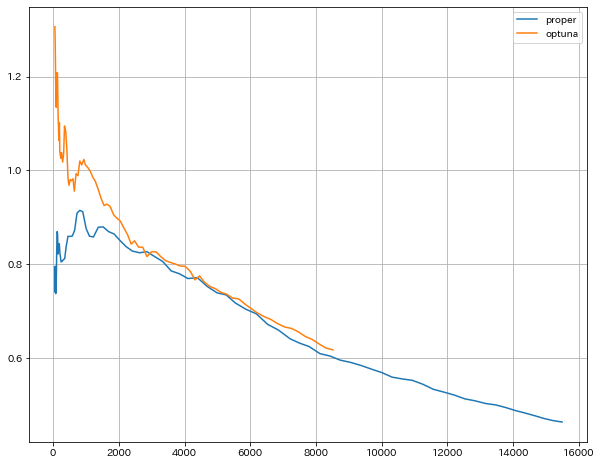

In [19]:
plt.figure(figsize=(10, 8))
gain_proper.rename('proper').plot(legend=True)
gain_optuna.rename('optuna').plot(legend=True)
plt.grid()

In [20]:
gain_optuna.max()

1.306776185176064